## 0) - Initialisation

### A) - Import des librairies

In [ ]:
import torch as tch
import torchvision as tchvs
from PIL import Image

import imageio.v2 as imageio
import matplotlib.pyplot as plt

print("CUDA disponible :", tch.cuda.is_available())
print("Version CUDA :", tch.version.cuda)
print("Version PyTorch :", tch.__version__)

CUDA disponible : True
Version CUDA : 12.4
Version PyTorch : 2.5.1+cu124


CUDA (Compute Unified Device Architecture) est une API développée par NVIDIA qui permet d’exécuter des calculs massivement parallèles sur les cartes graphiques compatibles. PyTorch peut utiliser CUDA pour accélérer les calculs, en particulier pour les réseaux de neurones profonds, où les opérations matricielles sont très coûteuses en temps de calcul sur un CPU.
PyTorch utilise ```device``` pour définir sur quelle unité de calcul les tenseurs et les modèles doivent être placés.

In [ ]:
#device = 'cuda'
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

### B) - Chargement des images

In [ ]:
#chargement des images
content_img = Image.open('content.JPG')
style_img = Image.open('style.jpg')


# Rotation de -90° (sens horaire)
content_img = content_img.rotate(90, expand=True)

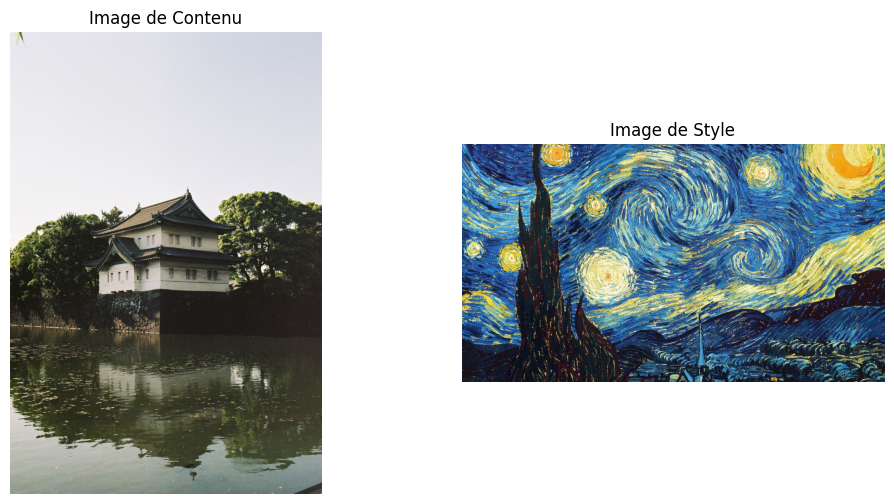

In [ ]:
# Afficher les deux images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Affichage de l'image de contenu (après rotation)
axes[0].imshow(content_img)
axes[0].set_title("Image de Contenu")
axes[0].axis("off")

# Affichage de l'image de style
axes[1].imshow(style_img)
axes[1].set_title("Image de Style")
axes[1].axis("off")

# Montrer l'affichage
plt.show()

Premier Réseau de neurone
Ici on cherche à Extraire le contexte de l'image cible

Ici on ne recupere que la partie convolutionelle du réseau sans le classifieur

## 1) - Matrice de Gram

Pour obtenir une représentation du style d'une image, il faut capturer les relations entre ses pixels, en particulier leurs corrélations spatiales et les motifs qu'ils forment. Un moyen efficace de formaliser ces relations est d'utiliser la matrice de Gram.

La matrice de Gram est construite à partir des représentations d'une image extraites par un réseau de neurones convolutifs (CNN). Plus précisément, si nous considérons une couche convolutionnelle donnée, ses activations peuvent être représentées sous la forme d'un tenseur
$𝐹$ de dimensions
$𝐶×𝐻×𝑊$ où :


*   $C$ est le nombre de filtres (ou canaux) de la couche,
*   $H$ et $W$ sont respectivement la hauteur et la largeur des activations.


La matrice de Gram $G$ est alors définie comme :

$$G_{ij} = ∑_{𝑘}F_{ik}F_{𝑗𝑘} $$
où $i$ et $j$ désignent deux canaux du tenseur
d'activation, et la somme est effectuée sur toutes les positions spatiales $k$ (c'est-à-dire les pixels des activations).

Cette matrice capture les corrélations entre les différentes réponses des filtres de la couche considérée. Plus précisément :

Un coefficient
$G_{ij}$ élevé indique une forte similarité entre les activations des filtres $i$ et $j$, signifiant que ces filtres détectent des motifs similaires dans l'image.
En agrégeant ces informations sur l'ensemble des canaux, la matrice de Gram fournit une empreinte statistique de la texture et du style de l'image, indépendamment de la position absolue des motifs détectés.
Dans le cadre du transfert de style, cette propriété est exploitée en minimisant la différence entre les matrices de Gram de l’image cible (celle à styliser) et celles de l’image de style. Cette optimisation contraint l'image cible à adopter les corrélations statistiques propres au style de l’image de référence, ce qui permet d'obtenir une représentation fidèle de son apparence visuelle.

En résumé, la matrice de Gram est un outil clé pour capturer le style d’une image en modélisant les dépendances entre les activations des filtres d'un réseau convolutif. Elle permet ainsi de représenter des textures et des motifs globaux, indépendamment de la structure spatiale exacte de l’image.

In [ ]:
#Définition de la matrice de gram
def gram_matrix(tensor):
  _,depth, heigth, width = tensor.shape
  return tensor.view(depth, heigth*width).mm(tensor.view(depth, heigth*width).t())

## 2) - Le Modèle VGG19

### A) - Réseaux de neurones convolutifs

Un CNN (Convolutional Neural Network) est un type de réseau de neurones conçu pour traiter des données sous forme d'images. Il est largement utilisé en vision par ordinateur pour des tâches comme la classification, la détection d'objets et dans notre cas pour le transfert de style.

Un CNN est composé de plusieurs types de couches :

*   Couches convolutionnelles : appliquent des filtres (kernels) pour extraire des caractéristiques locales (bords, textures, motifs).
*   Couches de pooling : réduisent la taille des activations tout en conservant les caractéristiques essentielles (max-pooling ou average-pooling).
*  Couches entièrement connectées (Fully connected layer) : analysent les caractéristiques extraites pour effectuer une classification ou une régression.

Les intérêts de  l'utilisation des reseaux convolutifs sont multiples :

*   Partage des poids : les filtres convolutifs réduisent le nombre de paramètres, améliorant l’efficacité du réseau.

*   Invariance spatiale : détecte les motifs indépendamment de leur position dans l’image.

*   Hiérarchisation des caractéristiques : les premières couches détectent des formes simples (bords), tandis que les couches profondes capturent des motifs complexes.


Leur structure optimisée pour le traitement d’images permets aux CNN d'être plus efficace pour les cas d'usage de vision par ordinateur.

### B) - VGG19

Le modèle VGG19 est un réseau de neurones convolutifs (CNN) développé par l’équipe du Visual Geometry Group (VGG) de l’Université d’Oxford. Il s'agit d'une version approfondie du modèle VGG16, avec 19 couches de poids entraînables, d'où son nom.

Architecture
VGG19 suit une structure simple et hiérarchique composée de :

16 couches convolutionnelles (avec des filtres de taille 3x3),
5 couches de pooling (max-pooling 2x2) pour réduire la dimension,
3 couches entièrement connectées, suivies d’une activation softmax pour la classification.
Caractéristiques principales
Utilise exclusivement des convolutions 3x3 empilées pour extraire progressivement des caractéristiques complexes.
Profondeur accrue permettant une meilleure capture des caractéristiques par rapport aux modèles plus anciens comme AlexNet.
Très efficace pour l’extraction de caractéristiques et le transfert de style en raison de ses activations riches en informations texturales.
Pré-entraîné sur ImageNet, il est souvent utilisé pour des tâches de classification et d’extraction de style dans des applications comme le Neural Style Transfer.
Bien que performant, VGG19 est plus lourd en termes de calcul et de mémoire par rapport à des architectures plus modernes comme ResNet ou EfficientNet, qui optimisent la profondeur avec des connexions résiduelles ou une meilleure efficacité des convolutions.

In [ ]:
# Définition de la classe VGG héritant de nn.Module
class VGG(tch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()  # Appelle le constructeur de la classe parente nn.Module

        # Sélection des couches dont on veut extraire les caractéristiques (features)
        self.chosen_features = ['0', '5', '10', '19', '28']  # Couches spécifiques du réseau VGG19

        # Chargement du modèle VGG19 pré-entraîné et sélection des premières couches (jusqu'à la 29e)
        self.model = tchvs.models.vgg19(pretrained=True).features[:29]



    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

# Définition du modèle et passage en mode évaluation
model = VGG().to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s]


La librairie PyTorch nous permet d'importer le modèle VGG19 préentrainé. Dans notre cas nous n'utilisons pas le classifieur  du modèle et nous n'importons que les couches convolutives.

In [ ]:
print(tchvs.models.vgg19())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
print(model)

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

#### I) - Structure des données d’entrée dans VGG19

VGG19 accepte des images sous forme de tenseur 4D de dimensions :

$$(Batch,Hauteur,Largeur,Canaux)$$
où :

Batch = Nombre d’images traitées simultanément (souvent 1 en transfert de style).
Hauteur & Largeur = Taille de l’image  $224*224$ pour ImageNet sur lequel VGG19 a été entrainé (VGG19 n'impose pas de taille d'entrée et peut ainsi traiter n'importe quelle dimension, typiquement $512*512$ ou $1024*1024$ pour un rendu détaillé; au delà la consommation mémoire devient trop importante).
Canaux = $3$ (images RGB).
Chaque pixel est encodé sous la forme d’un vecteur (R, G, B) avec des valeurs normalisées par la soustraction de la moyenne des canaux d’ImageNet (pré-processing standard de VGG19).

#### II) - Redimensionnement des images

Le redimensionnement est essentiel dans le transfert de style car :

VGG19 nécessite une entrée de taille cohérente

Il a été entraîné sur ImageNet, qui utilise des images de $224*224$.
Pour utiliser directement ses couches convolutives pré-entraînées, les images doivent être converties à une taille compatible.
Assurer une correspondance entre contenu et style

Si l’image de style et l’image de contenu ont des tailles très différentes, leur comparaison à travers les matrices de Gram devient incohérente.
Redimensionner permet d’harmoniser les dimensions et de garantir un transfert plus fidèle des textures et des motifs stylistiques.
Optimiser le calcul et la mémoire

Des images trop grandes alourdissent le traitement, notamment lorsque l’on calcule les activations et les pertes de contenu/style.
Redimensionner à une taille raisonnable permet d’équilibrer qualité visuelle et coût computationnel.
Préserver les caractéristiques essentielles de l’image

Lors du redimensionnement, on privilégie des méthodes comme l’interpolation bilinéaire ou bicubique pour éviter une perte excessive d’informations.
Certaines implémentations préfèrent redimensionner l’image de style à la taille de l’image de contenu pour un transfert plus naturel.
Conclusion
Dans le transfert de style avec VGG19, le redimensionnement des images est une étape clé pour garantir une compatibilité avec le réseau, assurer une comparaison cohérente entre contenu et style, et optimiser l’efficacité computationnelle du processus.

In [ ]:

img_size = 1024
#on créer une fonction qui permet des faire en sorte que les images soient de même taille et normaliser
transform = tchvs.transforms.Compose([
    tchvs.transforms.Resize((img_size, img_size)),
    tchvs.transforms.ToTensor(),
    #tchvs.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #pas forcément nécessaire
])

input_image = transform(content_img)
style_image = transform(style_img)


input_image_vs = transform(content_img)
style_image_vs = transform(style_img)

input_image_vs = tch.transpose(input_image_vs,0,2)
style_image_vs = tch.transpose(style_image_vs,0,2)


input_image = input_image.unsqueeze(0).to(device)
style_image = style_image.unsqueeze(0).to(device)

img_test = tch.randn(input_image.shape, requires_grad = True, device = device)

#img_test = input_image.clone().requires_grad_(True)

#img_test = style_image.clone().requires_grad_(True)

#image_test  = transform(test).unsqueeze(0).to(device)
#img_test = image_test.clone().requires_grad_(True)




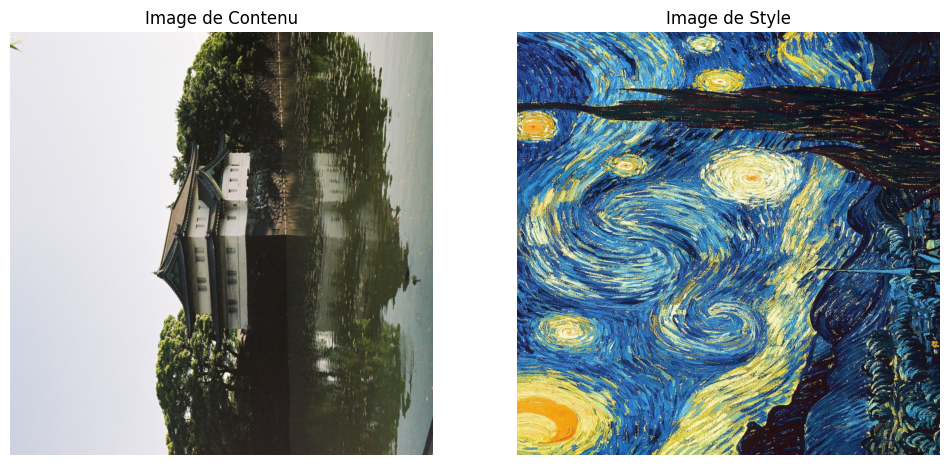

In [ ]:
# Afficher les deux images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Affichage de l'image de contenu (après rotation)
axes[0].imshow(input_image_vs)
axes[0].set_title("Image de Contenu")
axes[0].axis("off")

# Affichage de l'image de style
axes[1].imshow(style_image_vs)
axes[1].set_title("Image de Style")
axes[1].axis("off")

# Montrer l'affichage
plt.show()

## 2) - Transferts de style

Ici on va entrainer le reseaux pour qu'il puisse generer les images que l'on veut, pour l'application nous implémentons deux optimiseurs différents pour étudier l'influence.

### A) - Optimiseur LBFGS

Le premier est l'optimiseur LBFGS: LBFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) est une méthode d'optimisation quasi-Newtonienne qui approxime la matrice hessienne (la seconde dérivée de la fonction de coût) pour accélérer la convergence. Contrairement aux méthodes de descente de gradient classiques, LBFGS utilise une information sur la courbure pour choisir des pas de mise à jour plus intelligents.

On rappel les paramètres en jeu :
* $\alpha$ est l'hyper-paramètre qui permet de controler l'importance de la reconstruction du contenu de l'image cible.
* $\beta$ est l'hyper-paramètre qui permet de contrôler l'importance de la reconstruction du style de l'image de texture.
* ``lr`` correspond au learning rate  
* ``N_iter`` correspond au nombre d'itération pendant lequel nous allons optimiser la fonction de coût
* ``content_layer_index`` correspond à la couche  convolutive de représention que nous souhaitons optimiser (plus il est grand plus l'abstraction est importante)
* ``style_layer_index`` correspond aux couches convolutives que nous utilisons pour faire la reconstustruction stylistique

In [ ]:
N_iter = 500

#content loss
alpha = 10
#style loss
beta = 10e-5

content_layer_index = model.chosen_features.index('5')  # Correction de l'index

style_layer_index = [0,1,2,3,4]

optimizer = tch.optim.LBFGS([img_test])
#loss = tch.nn.MSELoss(reduction = 'mean')

L'optimiseur LBFGS dans PyTorch nécessite l'implémentation d'une méthode closure, ce qui n’est pas le cas d'autres optimisateurs comme Adam ou SGD. Cette exigence est due à la manière dont LBFGS met à jour les poids du modèle en utilisant une recherche de pas de gradient (line search).

LBFGS suit une approche différente des optimisations classiques : Il ne met pas à jour les paramètres à chaque itération de manière simple comme Adam ou SGD. Il ajuste dynamiquement le taux d’apprentissage en trouvant un pas optimal (line search).
Pour cela, il doit réévaluer plusieurs fois la fonction de perte et recalculer les gradients.

La méthode closure() est une fonction qui :
Recalcule la perte pour éviter d’utiliser un gradient obsolète.
Réalise une passe avant (forward) et arrière (backward) du modèle.
Retourne la perte à l’optimiseur LBFGS, qui l’utilise pour ajuster son estimation du pas de mise à jour.


In [ ]:
def closure():
  optimizer.zero_grad()
  test = model(img_test)
  style = model(style_image)
  content = model(input_image)


  content_loss = (1/2)*tch.mean((test[content_layer_index] -content[content_layer_index])**2)
  style_loss = 0


  for layer in style_layer_index:
        _,c,h,w = test[layer].shape
        G = gram_matrix(test[layer])
        A = gram_matrix(style[layer])
        style_loss += (1/2)*tch.mean((G-A)**2)

  total_loss = alpha*content_loss + beta*style_loss

  total_loss.backward()
  return total_loss


tch.cuda.empty_cache()


for epoch in range(N_iter):
  optimizer.step(closure)
  if epoch % 100 == 0:
    print("epoch : ",epoch)
    print(closure())


tchvs.utils.save_image(img_test, "image_final_LBFGS.png")

epoch :  0
tensor(56624.0898, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  100
tensor(5.7697, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  200
tensor(4.5867, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  300
tensor(4.3080, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  400
tensor(4.1671, device='cuda:0', grad_fn=<AddBackward0>)


### B) - L'optimiseur ADAM

L’optimiseur Adam (Adaptive Moment Estimation) est une méthode avancée de descente de gradient qui combine le momentum et l’adaptation du taux d’apprentissage pour une convergence plus rapide et stable. Il est largement utilisé en deep learning en raison de sa robustesse et de son efficacité, notamment sur des modèles complexes.

In [ ]:
N_iter = 50000
lr = 1e-3
#content loss
alpha = 10
#style loss
beta = 10e-5

content_layer_index = model.chosen_features.index('5')  # Correction de l'index

style_layer_index = [0,1,2,3,4]

In [ ]:
optimizer = tch.optim.Adam([img_test],lr =lr)
#loss = tch.nn.MSELoss(reduction = 'mean')
style_loss = 0

for epoch in range(N_iter):
  optimizer.zero_grad()
  test = model(img_test)
  style = model(style_image)
  content = model(input_image)

  content_loss = (1/2)*tch.mean((test[content_layer_index] -content[content_layer_index])**2)
  style_loss = 0


  for layer in style_layer_index:
        G = gram_matrix(test[layer])
        A = gram_matrix(style[layer])
        style_loss += (1/2)*tch.mean((G-A)**2)



  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print("epoch : ",epoch)
    print(total_loss)


tchvs.utils.save_image(img_test, "image_final_adam.png")


epoch :  0
tensor(1.8922e+08, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  1000
tensor(8986056., device='cuda:0', grad_fn=<AddBackward0>)
epoch :  2000
tensor(2471552.5000, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  3000
tensor(940235.3750, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  4000
tensor(412256.8750, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  5000
tensor(203326.7344, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  6000
tensor(112437.1094, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  7000
tensor(65588.2266, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  8000
tensor(38370.3164, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  9000
tensor(22480.3574, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  10000
tensor(13570.7754, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  11000
tensor(8602.4170, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  12000
tensor(5729.9346, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  13000
tensor(3931.6084, dev

KeyboardInterrupt: 

In [ ]:
tchvs.utils.save_image(img_test, "image_final_adam.png")

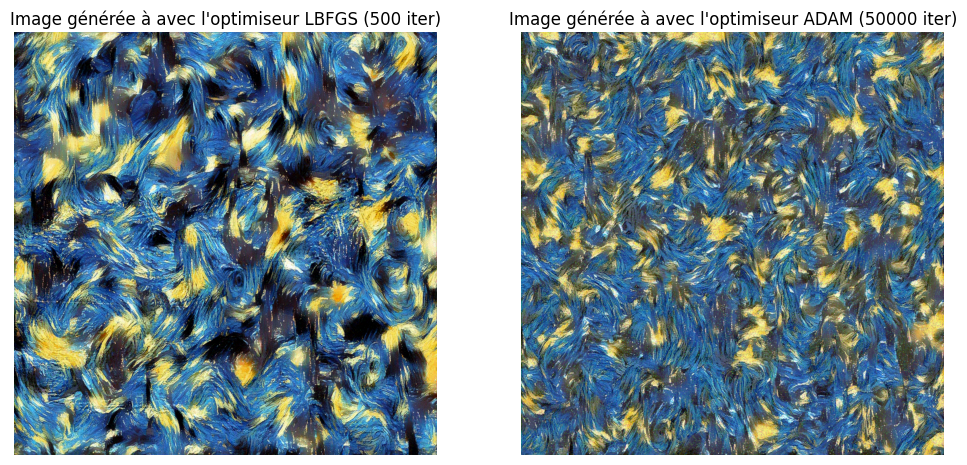

In [ ]:
img_LBFGS = Image.open('image_final_LBFGS.png')
img_ADAM = Image.open('image_final_adam.png')

# Afficher les deux images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Affichage de l'image de contenu (après rotation)
axes[0].imshow(img_LBFGS)
axes[0].set_title("Image générée à avec l'optimiseur LBFGS (500 iter)")
axes[0].axis("off")

# Affichage de l'image de style
axes[1].imshow(img_ADAM)
axes[1].set_title("Image générée à avec l'optimiseur ADAM (50000 iter)")
axes[1].axis("off")

# Montrer l'affichage
plt.show()